In [1]:
import os

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

In [2]:
nside = 512
cube1 = fits.getdata('../bass_dr8_iso_hpxcube_v0.fits.gz', 0)
cube2 = fits.getdata('../decals_dr8_iso_hpxcube_v4.fits.gz', 0)
cube_dm = fits.getdata('../bass_dr8_iso_hpxcube_v0.fits.gz', 1)
n_slice = len(cube_dm)

In [4]:
pix_idx = np.arange(hp.nside2npix(nside), dtype=int)
pix_c = hp.pix2ang(nside, pix_idx, 
                   lonlat=True)
pix_c = coord.SkyCoord(pix_c[0]*u.deg, pix_c[1]*u.deg)

In [5]:
pix_gal = pix_c.transform_to(coord.Galactic)
pix_l = pix_gal.l
pix_b = pix_gal.b

In [6]:
cube1 = fits.getdata('../bass_dr8_iso_hpxcube_v0.fits.gz', 0)
cube2 = fits.getdata('../decals_dr8_iso_hpxcube_v4.fits.gz', 0)

In [7]:
blobs = at.Table.read('/Users/apricewhelan/data/Misc/MW_dwarfs_globs.fits')
blobs = blobs[blobs['DM'] < 25]
blobs_c = coord.SkyCoord(blobs['ra']*u.deg,
                         blobs['dec']*u.deg,
                         coord.Distance(distmod=blobs['DM']))

In [28]:
blobs[blobs['name'] == 'NGC 6341 (M 92)']

<Table length=1>
      name         ra     dec           DM          dist    EBV     r_h  
    bytes21     float64 float64      float64      float64 float64 float64
--------------- ------- ------- ----------------- ------- ------- -------
NGC 6341 (M 92) 259.281  43.136 14.59539046188037     8.3   1e+20    10.0

In [8]:
# cube = cube1 + cube2
# cube1_mask = np.sum(cube1, axis=1) != 0
# cube2[cube1_mask] = 0.
cube2_mask = np.sum(cube2, axis=1) != 0
cube1[cube2_mask] = 0.
cube = cube1 + cube2

In [16]:
for i, dist in enumerate(coord.Distance(distmod=cube_dm)):
    print(f'{dist:.1f}: {i}')

6.3 kpc: 0
6.6 kpc: 1
6.9 kpc: 2
7.2 kpc: 3
7.6 kpc: 4
7.9 kpc: 5
8.3 kpc: 6
8.7 kpc: 7
9.1 kpc: 8
9.5 kpc: 9
10.0 kpc: 10
10.5 kpc: 11
11.0 kpc: 12
11.5 kpc: 13
12.0 kpc: 14
12.6 kpc: 15
13.2 kpc: 16
13.8 kpc: 17
14.5 kpc: 18
15.1 kpc: 19
15.8 kpc: 20
16.6 kpc: 21
17.4 kpc: 22
18.2 kpc: 23
19.1 kpc: 24
20.0 kpc: 25
20.9 kpc: 26
21.9 kpc: 27
22.9 kpc: 28
24.0 kpc: 29
25.1 kpc: 30
26.3 kpc: 31
27.5 kpc: 32
28.8 kpc: 33
30.2 kpc: 34
31.6 kpc: 35
33.1 kpc: 36
34.7 kpc: 37
36.3 kpc: 38
38.0 kpc: 39
39.8 kpc: 40
41.7 kpc: 41
43.7 kpc: 42
45.7 kpc: 43
47.9 kpc: 44
50.1 kpc: 45
52.5 kpc: 46
55.0 kpc: 47
57.5 kpc: 48
60.3 kpc: 49
63.1 kpc: 50
66.1 kpc: 51
69.2 kpc: 52
72.4 kpc: 53
75.9 kpc: 54
79.4 kpc: 55
83.2 kpc: 56
87.1 kpc: 57
91.2 kpc: 58
95.5 kpc: 59
100.0 kpc: 60
104.7 kpc: 61


In [9]:
cubesum = np.sum(cube, axis=1)
footprint_mask = cubesum != 0

In [25]:
blobs[blobs['name'] == 'Segue(I)']

<Table length=1>
  name           ra                dec         ...   EBV     r_h  
bytes21       float64            float64       ... float64 float64
-------- ------------------ ------------------ ... ------- -------
Segue(I) 151.76666666666665 16.081944444444446 ...   0.031     4.4

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


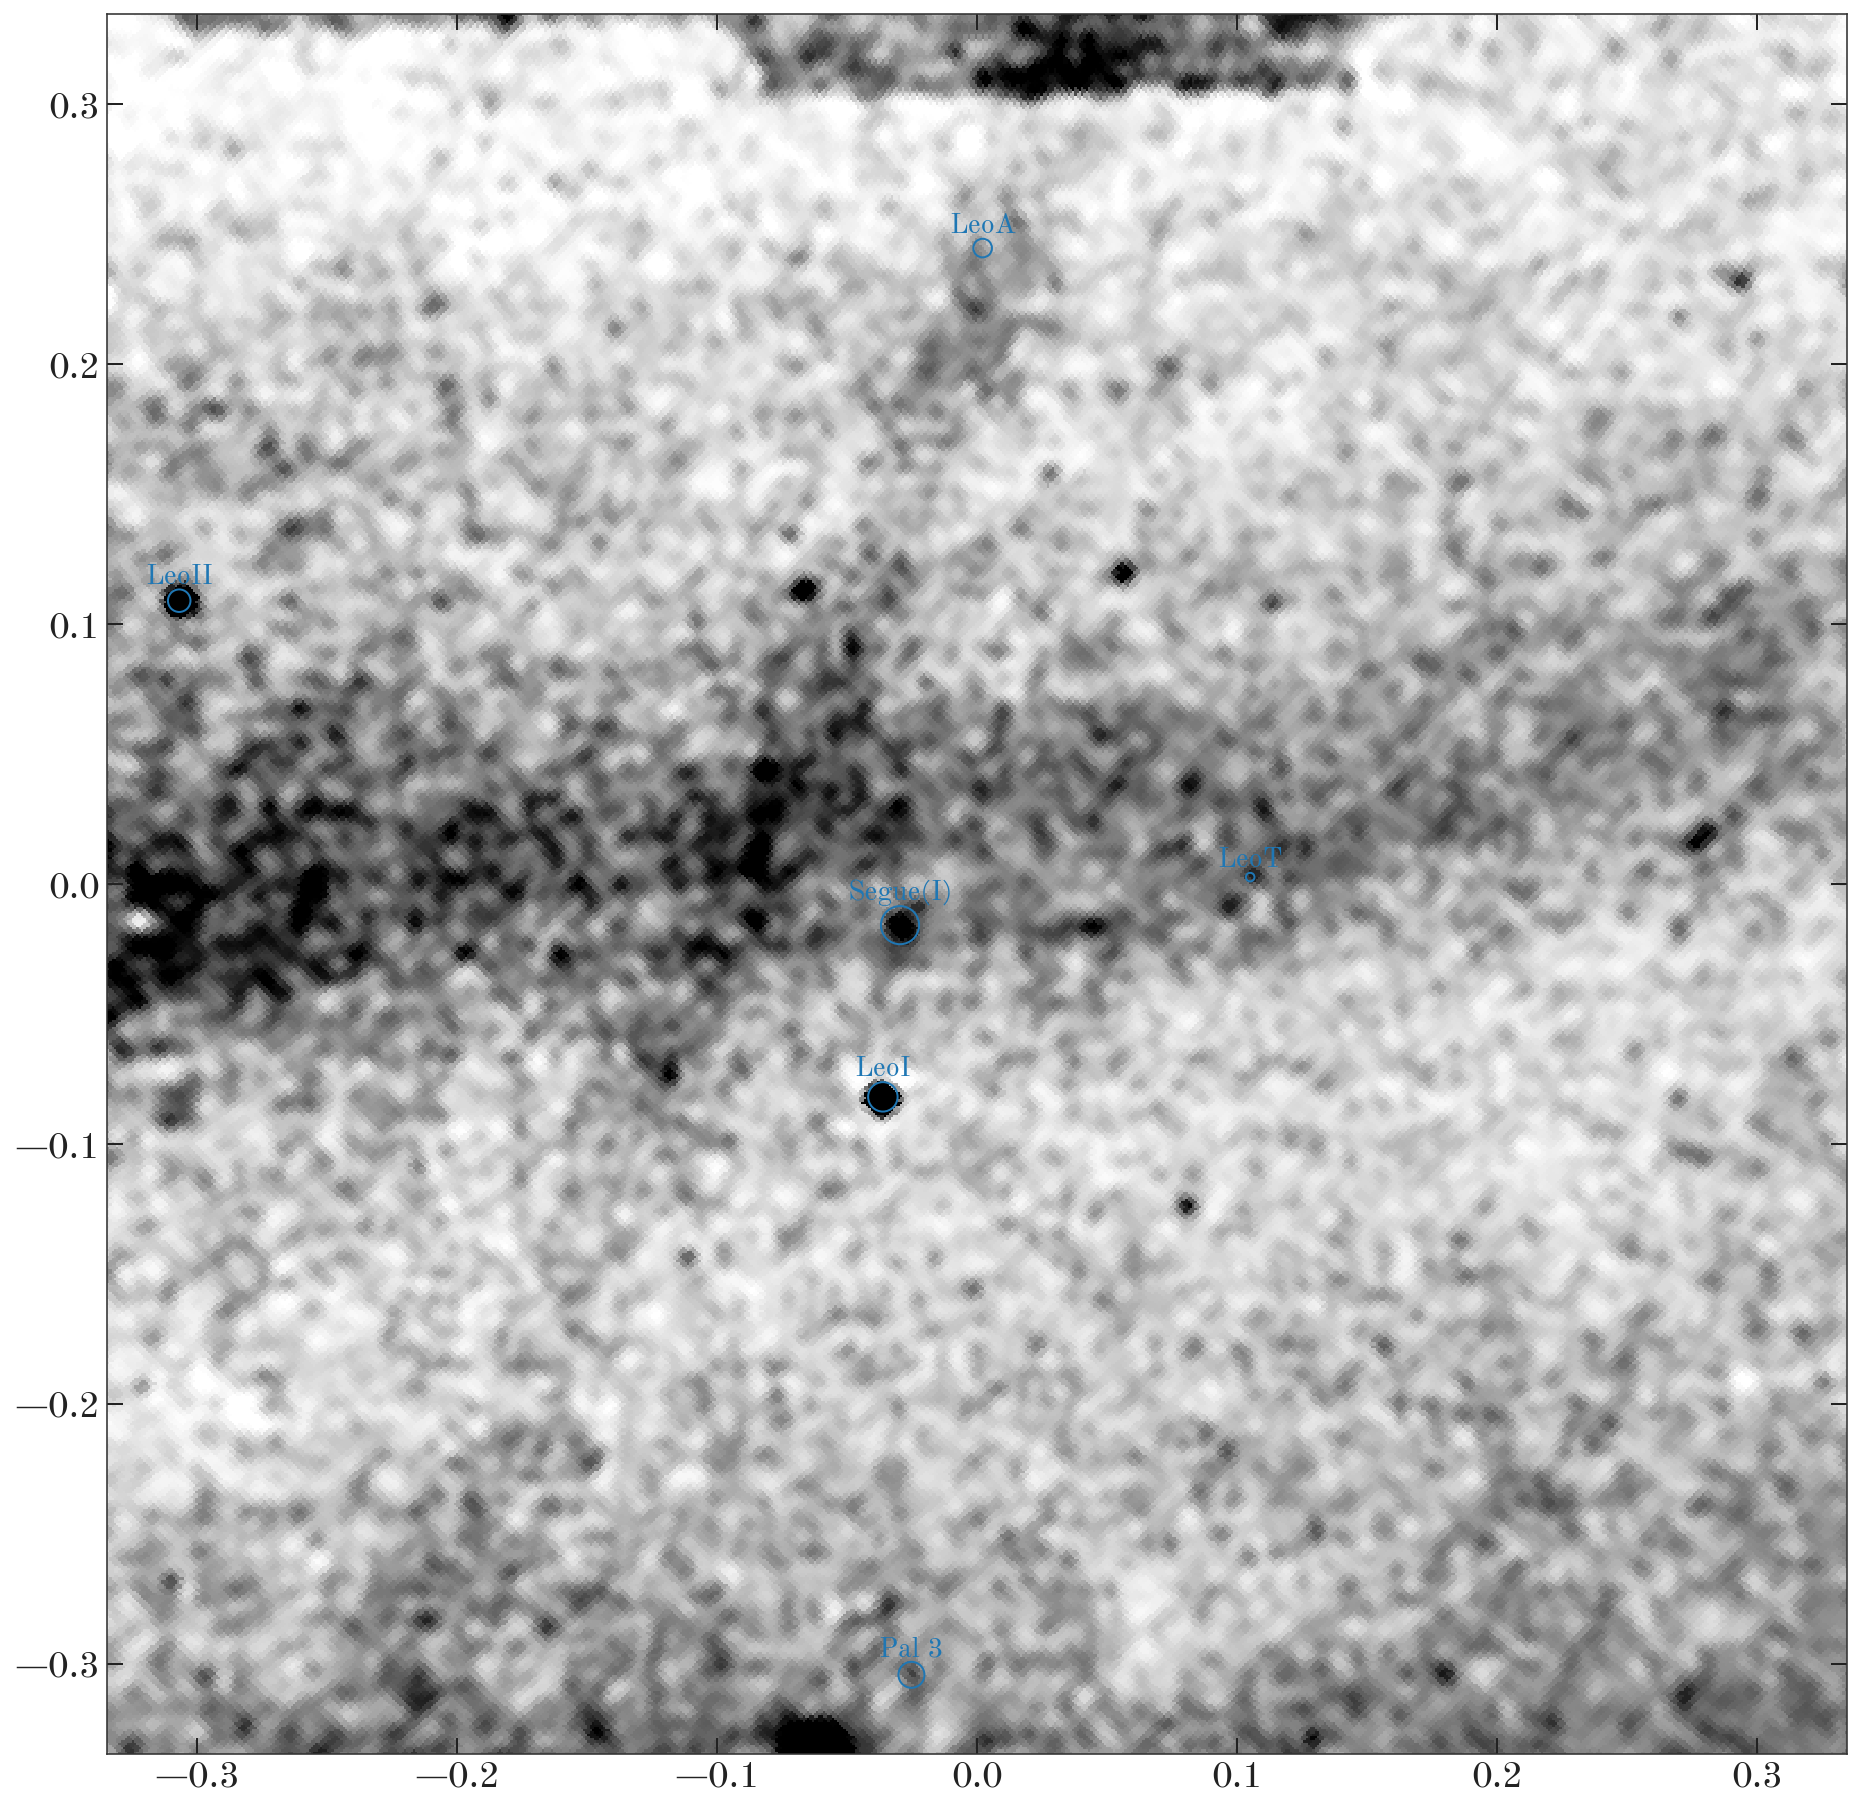

In [22]:
proj = hp.projector.GnomonicProj(reso=3, rot=[150, 17, 0],
                                 xsize=768, ysize=768)

X = cube[:, 29:].sum(axis=1)
X = hp.smoothing(X, sigma=np.radians(0.15))
X = X - hp.smoothing(X, sigma=np.radians(8.))
im = proj.projmap(X, func) 
vmin, vmax = np.percentile(im[im != 0.], [1, 99.5])

im = proj.projmap(X, func) 

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(im, origin='bottom', extent=proj.get_extent(),
          vmin=vmin, vmax=vmax, cmap='Greys')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for k, (row2, c2) in enumerate(zip(blobs, blobs_c)):
    xy = proj.ang2xy(c2.ra.degree, c2.dec.degree, lonlat=True)

    if not xlim[0] < xy[0] < xlim[1] or not ylim[0] < xy[1] < ylim[1]:
        continue
    
    color = 'tab:blue'
    hack_radius = row2['r_h']/600
    ax.add_patch(mpl.patches.Circle(xy, radius=hack_radius,
                                    facecolor='none', 
                                    edgecolor=color, zorder=100, 
                                    linewidth=1))
    ax.text(xy[0], xy[1] + hack_radius, row2['name'], 
            color=color, zorder=200,
            fontsize=14, ha='center', va='bottom')

In [178]:
in_footprint_idx = []
for i, cl_c in enumerate(blobs_c):
    pix = hp.ang2pix(nside, cl_c.ra.degree, cl_c.dec.degree, 
                     lonlat=True)
    
    if footprint_mask[pix]:
        in_footprint_idx.append(True)
    else:
        in_footprint_idx.append(False)
        
in_footprint_idx = np.array(in_footprint_idx)

In [179]:
blobs[in_footprint_idx]

<Table length=11>
      name               ra         ...         EBV            r_h  
    bytes21           float64       ...       float64        float64
---------------- ------------------ ... -------------------- -------
         DracoII  238.1983333333333 ...                0.016     2.7
     UrsaMajorII 132.87499999999997 ...                0.094    16.0
        Willman1 162.33749999999998 ...                0.014     2.3
           Draco  260.0516666666666 ... 0.027000000000000003    10.0
       UrsaMinor 227.28541666666666 ...                0.032     8.2
    UrsaMajor(I) 158.71999999999997 ...                 0.02    11.3
 CanesVenaticiII 194.29166666666663 ...                 0.01     1.6
CanesVenatici(I) 202.01458333333332 ... 0.013999999999999999     8.9
        NGC 2419            114.535 ...                1e+20     5.0
 NGC 6205 (M 13)            250.422 ...                1e+20    15.0
        NGC 6229            251.745 ...                1e+20     4.0

In [285]:
all_plot_paths = []
for i, (row, c) in enumerate(zip(blobs, blobs_c)):
    if not in_footprint_idx[i]: 
        continue
    
    print(row['name'])
#     if row['name'] != 'UrsaMajorII':
#         continue
    
    plot_path = './{}'.format(row['name'])
    all_plot_paths.append(plot_path)
    os.makedirs(plot_path, exist_ok=True)
    
    proj = hp.projector.GnomonicProj(reso=3, rot=[c.ra.degree, c.dec.degree],
                                     xsize=768, ysize=768)
    
    # j = np.argmin(np.abs(cube_dm - row['DM']))
    # X = proj.projmap(cube[:, j], func)
    # vmax = np.percentile(X[X != 0], 99.9)
    
    j = n_slice // 2
    # X = np.sum(cube[:, 2*j:2*j+1], axis=1)
    X = cube[:, j]
    X = hp.smoothing(X, sigma=np.radians(0.15))
    X = X - hp.smoothing(X, sigma=np.radians(8.))
    im = proj.projmap(X, func) 
    vmin, vmax = np.percentile(im[im != 0.], [1, 99])
    
    for j in range(n_slice):
        plot_filename = os.path.join(plot_path, f'{j:02d}.png')
        if os.path.exists(plot_filename):
            continue
        
        X = cube[:, j]
        
        # Simple:
        # im = proj.projmap(X, func)
        # vmax = np.percentile(X[X != 0], 99.9)
        
        # Unsharp mask:
        X = hp.smoothing(X, sigma=np.radians(0.15))
        X = X - hp.smoothing(X, sigma=np.radians(8.))
        im = proj.projmap(X, func) 
        # vmin, vmax = np.percentile(im[im != 0.], [2.5, 97.5])
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 16))
        ax.imshow(im, origin='bottom', extent=proj.get_extent(),
                  vmin=vmin, vmax=vmax, cmap='Greys')
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        for k, (row2, c2) in enumerate(zip(blobs, blobs_c)):
            xy = proj.ang2xy(c2.ra.degree, c2.dec.degree, lonlat=True)
            
            if not xlim[0] < xy[0] < xlim[1] or not ylim[0] < xy[1] < ylim[1]:
                continue
            
            if k == i:
                color = 'tab:red'
            else:
                color = 'tab:blue'
            hack_radius = row2['r_h']/600
            ax.add_patch(mpl.patches.Circle(xy, radius=hack_radius,
                                            facecolor='none', 
                                            edgecolor=color, zorder=100, 
                                            linewidth=1))
            ax.text(xy[0], xy[1] + hack_radius, row2['name'], 
                    color=color, zorder=200,
                    fontsize=14, ha='center', va='bottom')
            
        ax.set_title('{} DM={:.1f};  DM={:.1f}'
                     .format(row['name'], row['DM'], cube_dm[j]))
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        fig.tight_layout()
        fig.savefig(plot_filename, dpi=250)
        plt.close(fig)

DracoII
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
UrsaMajorII
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NGC 6205 (M 13)
Sigma is 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0

Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 480.000000 arcmin (0.139626 rad) 
-> fwhm is 1130.313622 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.000000 arcmin 

In [289]:
for plot_path in all_plot_paths:
    print(f'convert -delay 10  "{plot_path}/*.png" "{plot_path}/movie.gif"')

convert -delay 10  "./DracoII/*.png" "./DracoII/movie.gif"
convert -delay 10  "./UrsaMajorII/*.png" "./UrsaMajorII/movie.gif"
convert -delay 10  "./Willman1/*.png" "./Willman1/movie.gif"
convert -delay 10  "./Draco/*.png" "./Draco/movie.gif"
convert -delay 10  "./UrsaMinor/*.png" "./UrsaMinor/movie.gif"
convert -delay 10  "./UrsaMajor(I)/*.png" "./UrsaMajor(I)/movie.gif"
convert -delay 10  "./CanesVenaticiII/*.png" "./CanesVenaticiII/movie.gif"
convert -delay 10  "./CanesVenatici(I)/*.png" "./CanesVenatici(I)/movie.gif"
convert -delay 10  "./NGC 2419/*.png" "./NGC 2419/movie.gif"
convert -delay 10  "./NGC 6205 (M 13)/*.png" "./NGC 6205 (M 13)/movie.gif"
convert -delay 10  "./NGC 6229/*.png" "./NGC 6229/movie.gif"


Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 120.000000 arcmin (0.034907 rad) 
-> fwhm is 282.578405 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


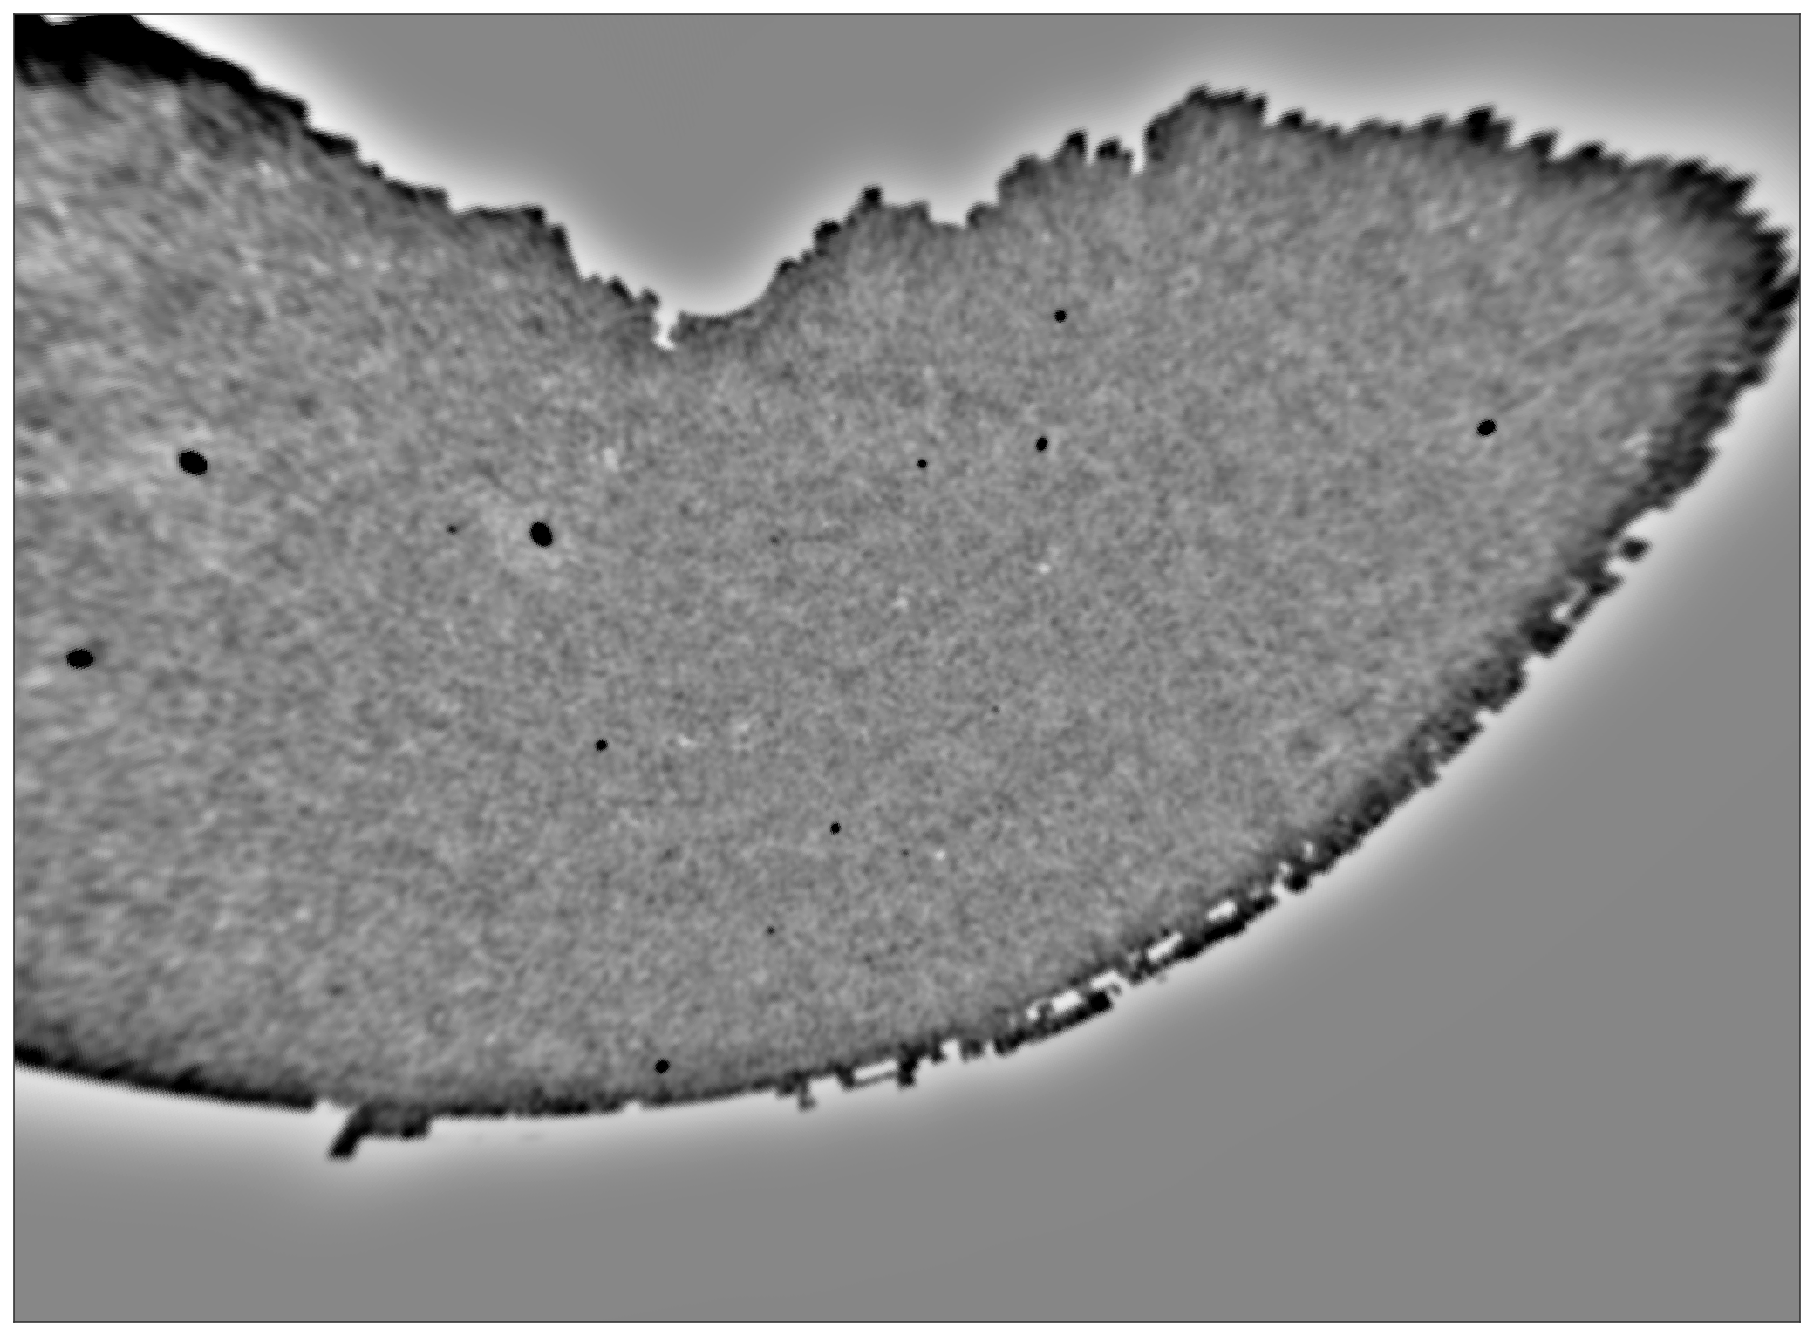

In [249]:
# proj = hp.projector.MollweideProj(xsize=2000, rot=180)

proj = hp.projector.GnomonicProj(reso=4, rot=[170, 57, 25.],
                                 xsize=2048, ysize=1500)

X = np.sum(cube[:, 18:36], axis=1)
X = hp.smoothing(X, sigma=np.radians(0.2)) - hp.smoothing(X, sigma=np.radians(2.))
im = proj.projmap(X, func) 
vmax = np.percentile(im, 99.5)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(im, origin='bottom', extent=proj.get_extent(), 
          cmap='Greys', vmax=vmax)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [116]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
        
    return np.clip((x - min) / (max - min), 0, 1)

In [1]:
# proj = hp.projector.MollweideProj(xsize=2000, rot=180)

proj = hp.projector.GnomonicProj(reso=4, rot=[136, 17, 25.],
                                 xsize=2048, ysize=1500)

rgb = np.stack((np.sum(cube[:, 36:], axis=1),
                np.sum(cube[:, 18:36], axis=1),
                np.sum(cube[:, :18], axis=1)), 
               axis=-1)
for i in range(3):
    rgb[..., i] = hp.smoothing(rgb[..., i], fwhm=np.radians(0.2))

# a = 1e-1
# rgb[..., 0] = np.arcsinh(apwnorm(rgb[..., 0])/a) / np.arcsinh(1/a)

# a = 1e-1
# rgb[..., 1] = np.arcsinh(apwnorm(rgb[..., 1])/a) / np.arcsinh(1/a)

# a = 1e-1
# rgb[..., 2] = np.arcsinh(apwnorm(rgb[..., 2])/a) / np.arcsinh(1/a)

for i in range(3):
    rgb[..., i] = apwnorm(rgb[..., i], max=np.percentile(rgb[..., i], 99))

rgb = np.stack([proj.projmap(rgb[:, i], func) 
                for i in range(3)], axis=-1)

NameError: name 'hp' is not defined

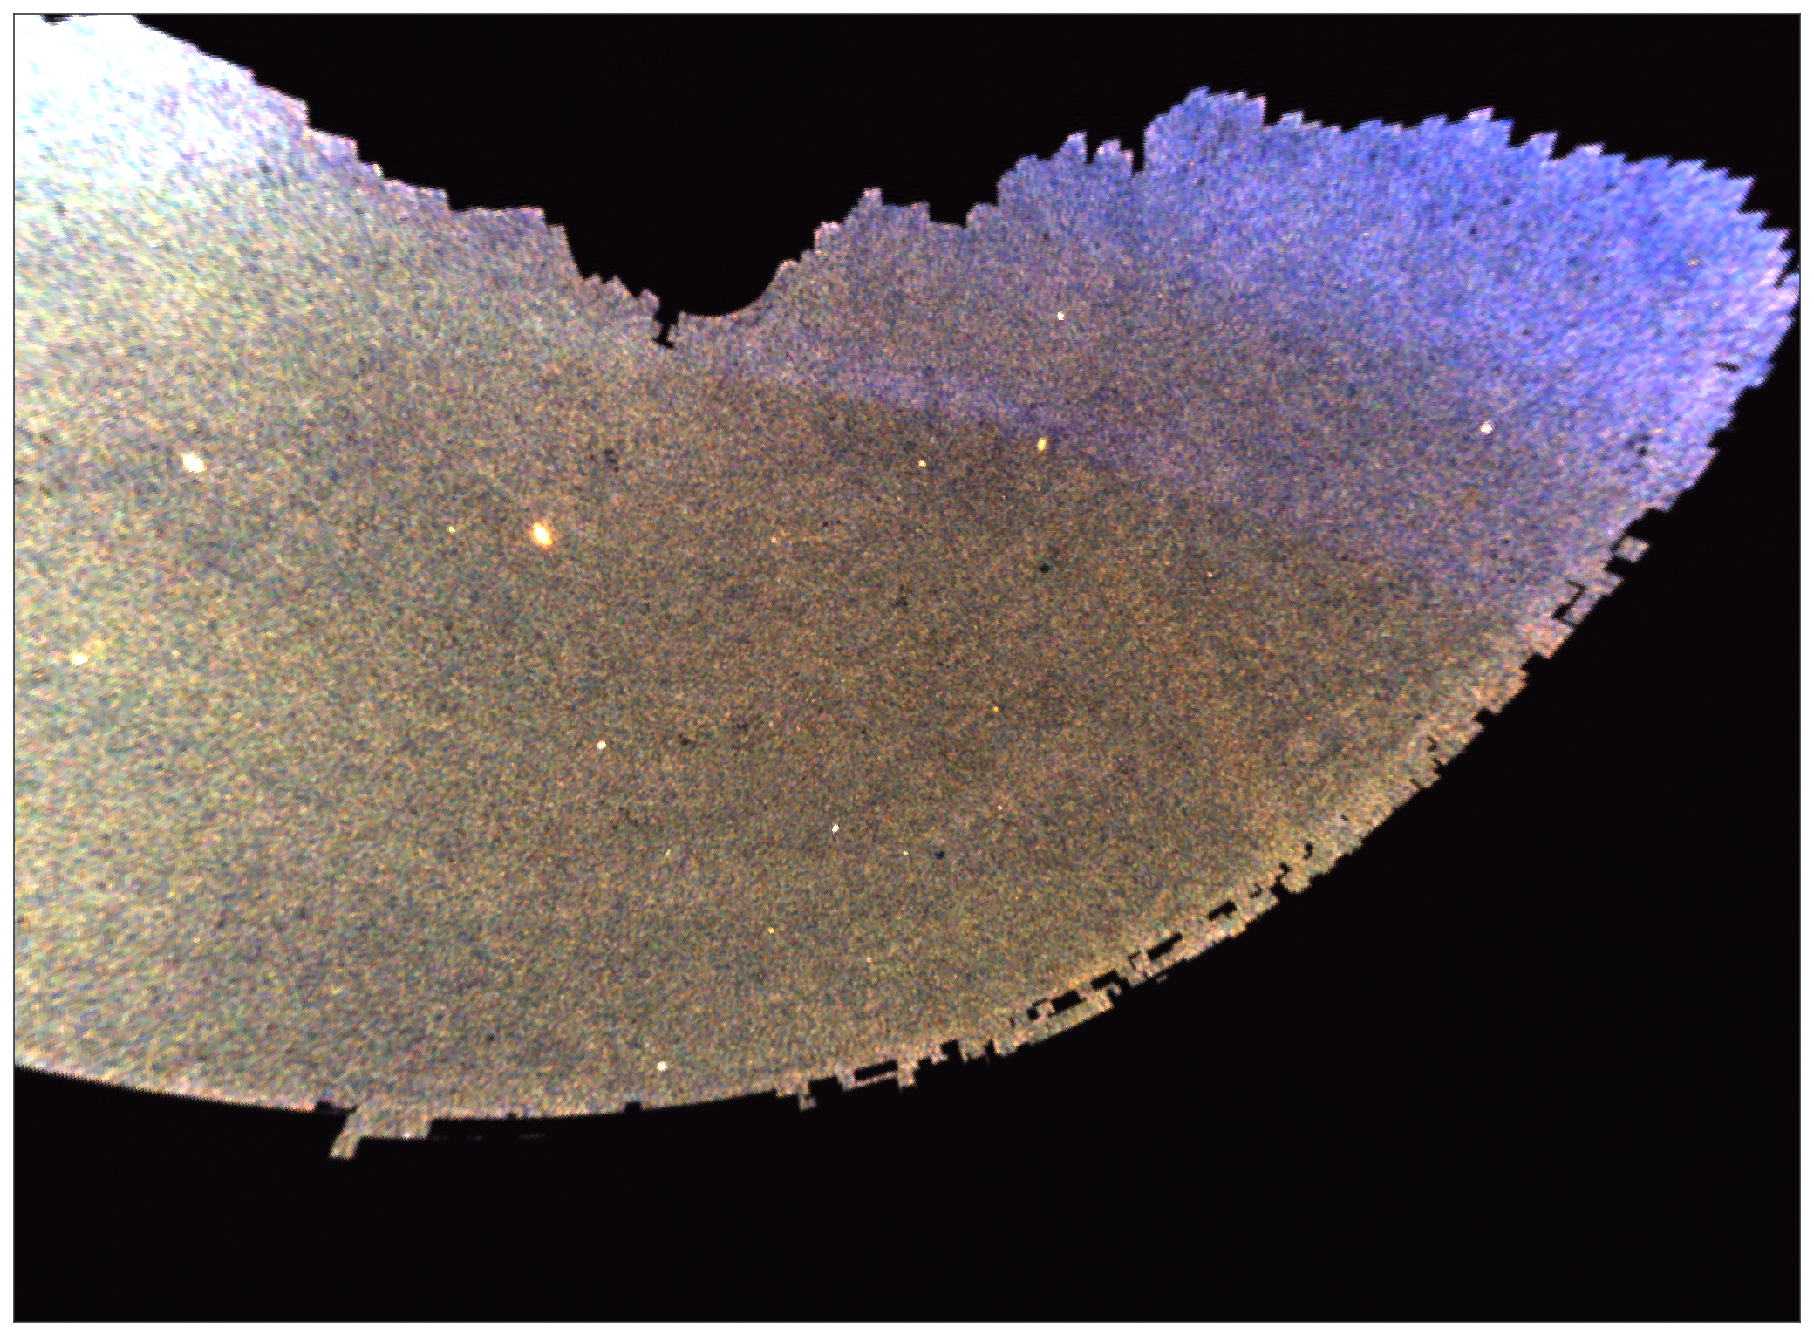

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(rgb, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)